# LSTM Multi-Output Regression with PyTorch

This notebook implements an LSTM-based multi-output regression model using PyTorch for predicting NBA player statistics.

## Key Features:
- LSTM architecture for sequence modeling
- Multi-output regression for multiple target variables
- PyTorch implementation with proper training loops
- Early stopping and learning rate scheduling
- Comprehensive evaluation metrics
- Model saving and loading capabilities

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
RANDOM_SEED = 42

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
def find_backend_dir(start_path=None):
    """
    Walk up directories from start_path (or cwd) until a folder named 'backend' is found.
    Returns the absolute path to the 'backend' folder.
    """
    if start_path is None:
        start_path = os.getcwd()
    curr_path = os.path.abspath(start_path)
    while True:
        # Check if 'backend' exists in this directory
        candidate = os.path.join(curr_path, "backend")
        if os.path.isdir(candidate):
            return candidate
        # If at filesystem root, stop
        parent = os.path.dirname(curr_path)
        if curr_path == parent:
            break
        curr_path = parent
    raise FileNotFoundError(f"No 'backend' directory found upward from {start_path}")

# Find the backend directory and CSV folder
backend_dir = find_backend_dir()
csv_dir = os.path.join(backend_dir, "CSVs")
models_dir = os.path.join(backend_dir, "Models")

print(f"Backend directory: {backend_dir}")
print(f"CSV directory: {csv_dir}")
print(f"Models directory: {models_dir}")

Backend directory: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend
CSV directory: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/CSVs
Models directory: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models


In [3]:
# Load the data
print("Loading training and test data...")
train = pd.read_csv(os.path.join(csv_dir, "train_season_features.csv"))
test = pd.read_csv(os.path.join(csv_dir, "test_season_features.csv"))

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"Training data columns: {len(train.columns)}")
print(f"Test data columns: {len(test.columns)}")

Loading training and test data...
Training data shape: (1912, 79)
Test data shape: (422, 79)
Training data columns: 79
Test data columns: 79


In [4]:
# Identify target and feature columns
target_cols = [c for c in train.columns if c.startswith("next_")]
feature_cols = [c for c in train.columns if c not in ["PERSON_ID", "SEASON_ID"] + target_cols]

print(f"Number of target variables: {len(target_cols)}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nTarget variables: {target_cols}")
print(f"\nFirst 10 features: {feature_cols[:10]}")

Number of target variables: 21
Number of features: 56

Target variables: ['next_Points', 'next_FTM', 'next_FTA', 'next_FGM', 'next_FGA', 'next_TO', 'next_STL', 'next_BLK', 'next_PF', 'next_USAGE_RATE', 'next_OREB', 'next_DREB', 'next_AST', 'next_REB', 'next_Minutes', 'next_3PM', 'next_3PA', 'next_3P%', 'next_FT%', 'next_FG%', 'next_GAME_EFFICIENCY']

First 10 features: ['Points', 'Minutes', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA']


In [5]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    train[feature_cols], train[target_cols], test_size=0.2, random_state=RANDOM_SEED
)
X_test, y_test = test[feature_cols], test[target_cols]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1529, 56)
X_val shape: (383, 56)
X_test shape: (422, 56)
y_train shape: (1529, 21)
y_val shape: (383, 21)
y_test shape: (422, 21)


In [6]:
# Handle infinite values and missing data
print("Handling infinite values and missing data...")

# Replace infinite values with NaN
for df_ in [X_train, X_val, y_train, y_val, X_test, y_test]:
    df_.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values
imputer_X = SimpleImputer(strategy='median')
imputer_y = SimpleImputer(strategy='median')

# Fit and transform features
X_train_imputed = pd.DataFrame(
    imputer_X.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_val_imputed = pd.DataFrame(
    imputer_X.transform(X_val), 
    columns=X_val.columns, 
    index=X_val.index
)
X_test_imputed = pd.DataFrame(
    imputer_X.transform(X_test), 
    columns=X_test.columns, 
    index=X_test.index
)

# Fit and transform targets
y_train_imputed = pd.DataFrame(
    imputer_y.fit_transform(y_train), 
    columns=y_train.columns, 
    index=y_train.index
)
y_val_imputed = pd.DataFrame(
    imputer_y.transform(y_val), 
    columns=y_val.columns, 
    index=y_val.index
)
y_test_imputed = pd.DataFrame(
    imputer_y.transform(y_test), 
    columns=y_test.columns, 
    index=y_test.index
)

print("Data preprocessing completed!")

Handling infinite values and missing data...
Data preprocessing completed!


In [7]:
# Scale the features and targets
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()  # Use MinMaxScaler for targets to keep them in reasonable range

# Scale features
X_train_scaled = pd.DataFrame(
    scaler_X.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)
X_val_scaled = pd.DataFrame(
    scaler_X.transform(X_val_imputed),
    columns=X_val_imputed.columns,
    index=X_val_imputed.index
)
X_test_scaled = pd.DataFrame(
    scaler_X.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

# Scale targets
y_train_scaled = pd.DataFrame(
    scaler_y.fit_transform(y_train_imputed),
    columns=y_train_imputed.columns,
    index=y_train_imputed.index
)
y_val_scaled = pd.DataFrame(
    scaler_y.transform(y_val_imputed),
    columns=y_val_imputed.columns,
    index=y_val_imputed.index
)
y_test_scaled = pd.DataFrame(
    scaler_y.transform(y_test_imputed),
    columns=y_test_imputed.columns,
    index=y_test_imputed.index
)

print("Feature and target scaling completed!")

Feature and target scaling completed!


In [8]:
# Create sequences for LSTM
def create_sequences(X, y, sequence_length=5):
    """
    Create sequences for LSTM training
    
    Parameters:
    -----------
    X : DataFrame
        Input features
    y : DataFrame
        Target values
    sequence_length : int
        Length of input sequences
    
    Returns:
    --------
    X_seq : array
        Input sequences
    y_seq : array
        Target values
    """
    X_seq = []
    y_seq = []
    
    for i in range(sequence_length, len(X)):
        X_seq.append(X.iloc[i-sequence_length:i].values)
        y_seq.append(y.iloc[i].values)
    
    return np.array(X_seq), np.array(y_seq)

# Create sequences
sequence_length = 10  # Use last 3 time steps to predict next
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, sequence_length)

print(f"Training sequences: {X_train_seq.shape}")
print(f"Validation sequences: {X_val_seq.shape}")
print(f"Test sequences: {X_test_seq.shape}")
print(f"Training targets: {y_train_seq.shape}")
print(f"Validation targets: {y_val_seq.shape}")
print(f"Test targets: {y_test_seq.shape}")

Training sequences: (1519, 10, 56)
Validation sequences: (373, 10, 56)
Test sequences: (412, 10, 56)
Training targets: (1519, 21)
Validation targets: (373, 21)
Test targets: (412, 21)


In [9]:
# Create PyTorch Dataset
class LSTMDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = LSTMDataset(X_train_seq, y_train_seq)
val_dataset = LSTMDataset(X_val_seq, y_val_seq)
test_dataset = LSTMDataset(X_test_seq, y_test_seq)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 24
Number of validation batches: 6
Number of test batches: 7


In [10]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_layers, output_size,
        dropout=0.5, bidirectional=True
    ):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * self.num_directions, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size, device=x.device)

        # LSTM forward
        lstm_out, _ = self.lstm(x, (h0, c0))
        # Take the last time step
        lstm_out = lstm_out[:, -1, :]

        # Fully connected layers
        out = self.relu(self.fc1(lstm_out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Example usage:
# model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0.5, bidirectional=True)
# model = model.to(device)

# Model parameters
input_size = X_train_scaled.shape[1]
output_size = y_train_scaled.shape[1]
hidden_size = 256
num_layers = 5
dropout = 0.5

# Create model
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=dropout, bidirectional=True)
model = model.to(device)

print(f"Model parameters:")
print(f"  Input size: {input_size}")
print(f"  Hidden size: {hidden_size}")
print(f"  Number of layers: {num_layers}")
print(f"  Output size: {output_size}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model parameters:
  Input size: 56
  Hidden size: 256
  Number of layers: 5
  Output size: 21

Total parameters: 7,087,637
Trainable parameters: 7,087,637


In [11]:
# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training parameters
num_epochs = 1000
patience = 50
best_val_loss = float('inf')
patience_counter = 0

# Lists to store training history
train_losses = []
val_losses = []

print("Starting training...")
print(f"Number of epochs: {num_epochs}")
print(f"Patience: {patience}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

Starting training...
Number of epochs: 1000
Patience: 50
Learning rate: 0.0005


In [12]:
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    # Calculate average losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    # Store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), os.path.join(models_dir, 'lstm_best_model.pth'))
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Patience: {patience_counter}/{patience}')
    
    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

print("Training completed!")

Epoch [10/1000], Train Loss: 0.0318, Val Loss: 0.0281, Patience: 4/50
Epoch [20/1000], Train Loss: 0.0302, Val Loss: 0.0275, Patience: 6/50
Epoch [30/1000], Train Loss: 0.0303, Val Loss: 0.0273, Patience: 16/50
Epoch [40/1000], Train Loss: 0.0303, Val Loss: 0.0273, Patience: 26/50
Epoch [50/1000], Train Loss: 0.0302, Val Loss: 0.0273, Patience: 36/50
Epoch [60/1000], Train Loss: 0.0301, Val Loss: 0.0273, Patience: 46/50
Early stopping at epoch 64
Training completed!


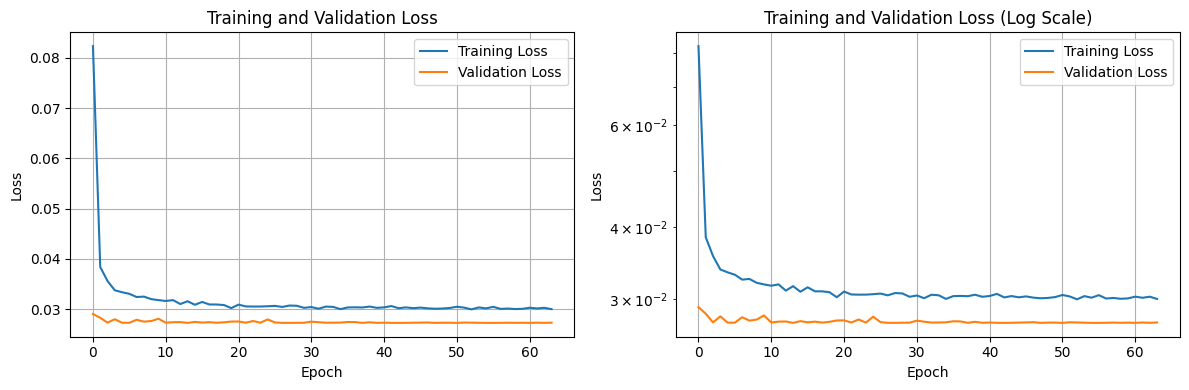

In [13]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Load best model
model.load_state_dict(torch.load(os.path.join(models_dir, 'lstm_best_model.pth')))
model.eval()

# Function to make predictions
def predict_lstm(model, data_loader, device):
    """
    Make predictions using the LSTM model
    
    Parameters:
    -----------
    model : nn.Module
        Trained LSTM model
    data_loader : DataLoader
        Data loader for the dataset
    device : torch.device
        Device to run predictions on
    
    Returns:
    --------
    predictions : array
        Predicted values
    """
    predictions = []
    
    with torch.no_grad():
        for batch_X, _ in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions.append(outputs.cpu().numpy())
    
    return np.concatenate(predictions, axis=0)

# Make predictions
print("Making predictions...")
val_pred_scaled = predict_lstm(model, val_loader, device)
test_pred_scaled = predict_lstm(model, test_loader, device)

print(f"Validation predictions shape: {val_pred_scaled.shape}")
print(f"Test predictions shape: {test_pred_scaled.shape}")

Making predictions...
Validation predictions shape: (373, 21)
Test predictions shape: (412, 21)


In [15]:
# Inverse transform predictions to original scale
val_pred = scaler_y.inverse_transform(val_pred_scaled)
test_pred = scaler_y.inverse_transform(test_pred_scaled)

# Get actual values (remove the first sequence_length samples)
val_actual = y_val_imputed.iloc[sequence_length:].values
test_actual = y_test_imputed.iloc[sequence_length:].values

print(f"Validation actual shape: {val_actual.shape}")
print(f"Test actual shape: {test_actual.shape}")

Validation actual shape: (373, 21)
Test actual shape: (412, 21)


In [16]:
# Evaluate on validation set
print("Evaluating on validation set...")

val_mae = mean_absolute_error(val_actual, val_pred)
val_r2 = r2_score(val_actual, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_actual, val_pred))

print(f"Validation MAE: {val_mae:.3f}")
print(f"Validation R²: {val_r2:.3f}")
print(f"Validation RMSE: {val_rmse:.3f}")

# Per-target evaluation
print("\nPer-target validation metrics:")
for i, target_name in enumerate(target_cols):
    target_mae = mean_absolute_error(val_actual[:, i], val_pred[:, i])
    target_r2 = r2_score(val_actual[:, i], val_pred[:, i])
    print(f"{target_name}: MAE={target_mae:.3f}, R²={target_r2:.3f}")

Evaluating on validation set...
Validation MAE: 3.536
Validation R²: -0.001
Validation RMSE: 6.258

Per-target validation metrics:
next_Points: MAE=5.711, R²=-0.002
next_FTM: MAE=1.299, R²=-0.003
next_FTA: MAE=1.548, R²=-0.006
next_FGM: MAE=2.023, R²=-0.001
next_FGA: MAE=4.302, R²=-0.000
next_TO: MAE=0.324, R²=-0.000
next_STL: MAE=0.297, R²=-0.001
next_BLK: MAE=0.733, R²=-0.001
next_PF: MAE=0.541, R²=-0.001
next_USAGE_RATE: MAE=9.789, R²=-0.000
next_OREB: MAE=0.576, R²=-0.000
next_DREB: MAE=1.430, R²=-0.000
next_AST: MAE=1.731, R²=-0.001
next_REB: MAE=1.835, R²=-0.000
next_Minutes: MAE=6.734, R²=0.000
next_3PM: MAE=0.774, R²=-0.000
next_3PA: MAE=1.962, R²=-0.000
next_3P%: MAE=7.703, R²=-0.000
next_FT%: MAE=9.041, R²=-0.001
next_FG%: MAE=5.631, R²=-0.006
next_GAME_EFFICIENCY: MAE=10.261, R²=-0.000


In [17]:
# Evaluate on test set
print("Evaluating on test set...")

test_mae = mean_absolute_error(test_actual, test_pred)
test_r2 = r2_score(test_actual, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Test MAE: {test_mae:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

# Per-target evaluation
print("\nPer-target test metrics:")
for i, target_name in enumerate(target_cols):
    target_mae = mean_absolute_error(test_actual[:, i], test_pred[:, i])
    target_r2 = r2_score(test_actual[:, i], test_pred[:, i])
    print(f"{target_name}: MAE={target_mae:.3f}, R²={target_r2:.3f}")

Evaluating on test set...
Test MAE: 3.721
Test R²: -0.097
Test RMSE: 6.479

Per-target test metrics:
next_Points: MAE=6.237, R²=-0.149
next_FTM: MAE=1.357, R²=-0.184
next_FTA: MAE=1.668, R²=-0.211
next_FGM: MAE=2.238, R²=-0.156
next_FGA: MAE=4.576, R²=-0.133
next_TO: MAE=0.335, R²=-0.036
next_STL: MAE=0.301, R²=-0.048
next_BLK: MAE=0.760, R²=-0.132
next_PF: MAE=0.643, R²=-0.257
next_USAGE_RATE: MAE=9.731, R²=-0.017
next_OREB: MAE=0.566, R²=-0.012
next_DREB: MAE=1.566, R²=-0.136
next_AST: MAE=1.637, R²=-0.094
next_REB: MAE=2.033, R²=-0.107
next_Minutes: MAE=8.157, R²=-0.187
next_3PM: MAE=0.759, R²=-0.002
next_3PA: MAE=1.944, R²=-0.000
next_3P%: MAE=6.991, R²=-0.000
next_FT%: MAE=9.165, R²=-0.000
next_FG%: MAE=5.871, R²=-0.028
next_GAME_EFFICIENCY: MAE=11.616, R²=-0.153


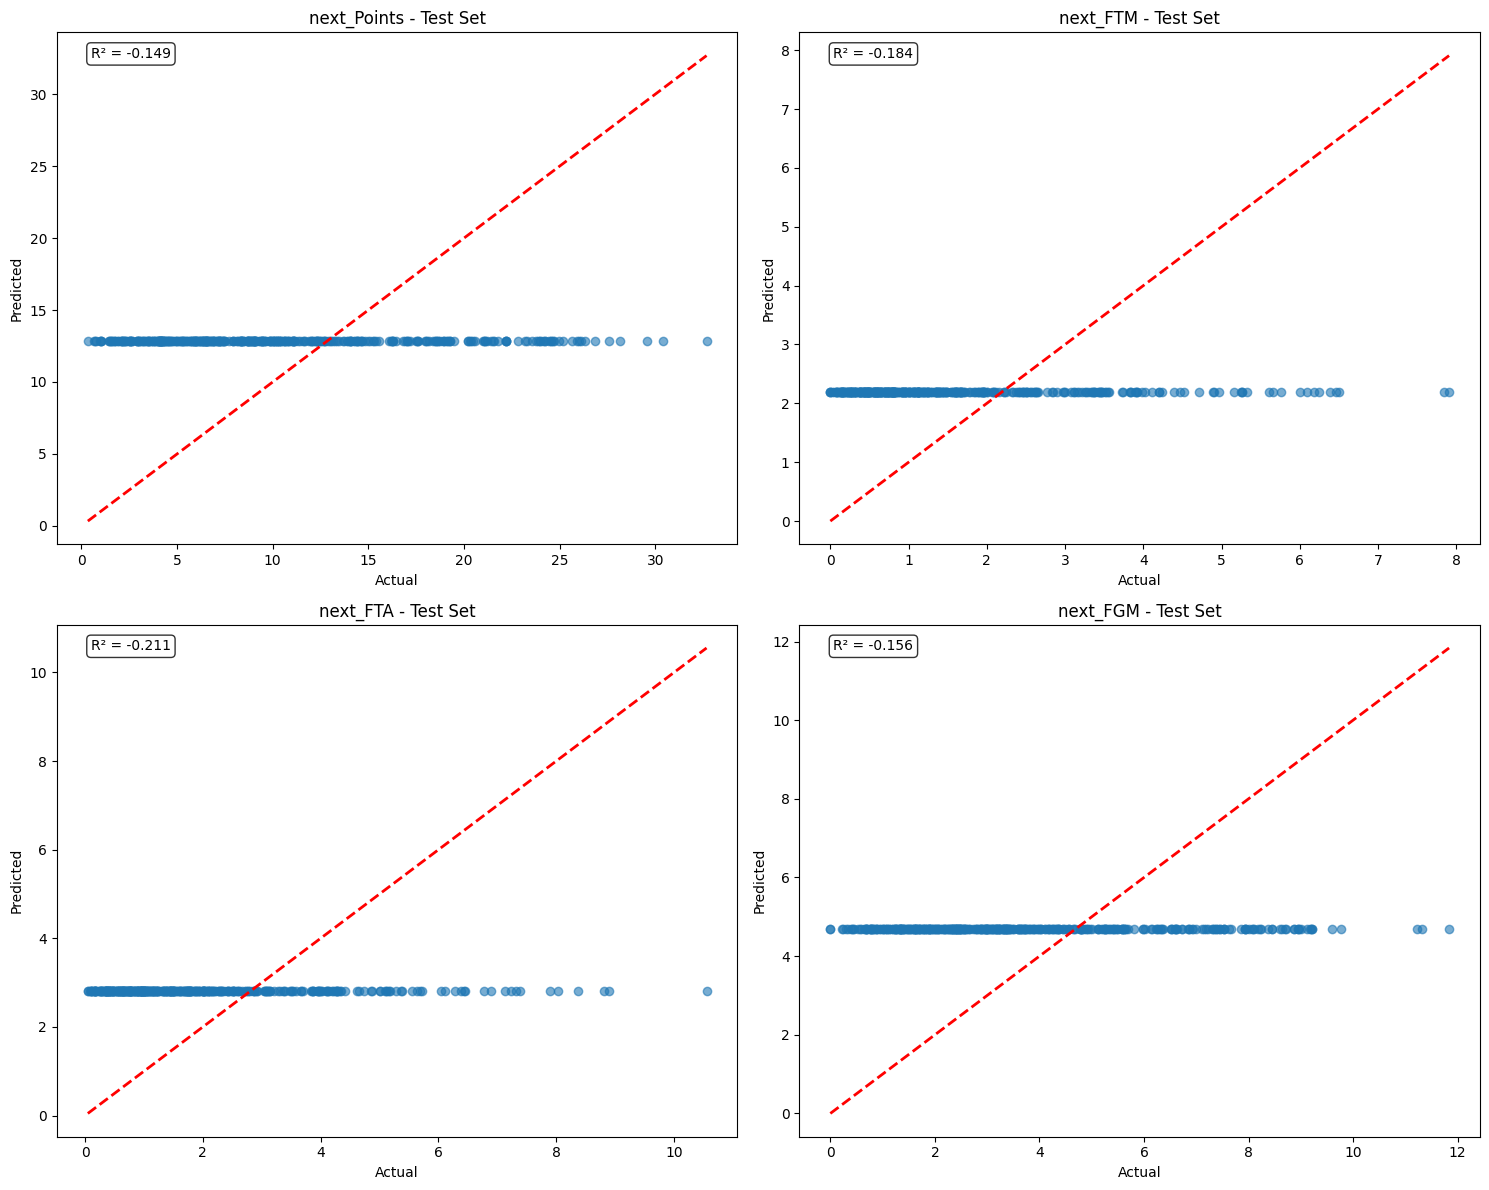

In [18]:
# Visualize predictions vs actual for a few targets
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i in range(min(4, len(target_cols))):
    axes[i].scatter(test_actual[:, i], test_pred[:, i], alpha=0.6)
    axes[i].plot([test_actual[:, i].min(), test_actual[:, i].max()], 
                 [test_actual[:, i].min(), test_actual[:, i].max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(f'{target_cols[i]} - Test Set')
    
    # Add R² to plot
    r2 = r2_score(test_actual[:, i], test_pred[:, i])
    axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[i].transAxes, 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [19]:
# Save the model and related objects
print("Saving model and related objects...")

# Save the model architecture and state
model_info = {
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'dropout': dropout,
    'sequence_length': sequence_length
}
model_info_path = os.path.join(models_dir, "lstm_model_info.joblib")
joblib.dump(model_info, model_info_path)
print(f"Model info saved to: {model_info_path}")

# Save the scalers
scaler_X_path = os.path.join(models_dir, "lstm_scaler_X.joblib")
scaler_y_path = os.path.join(models_dir, "lstm_scaler_y.joblib")
joblib.dump(scaler_X, scaler_X_path)
joblib.dump(scaler_y, scaler_y_path)
print(f"Scalers saved to: {scaler_X_path}, {scaler_y_path}")

# Save the imputers
imputer_X_path = os.path.join(models_dir, "lstm_imputer_X.joblib")
imputer_y_path = os.path.join(models_dir, "lstm_imputer_y.joblib")
joblib.dump(imputer_X, imputer_X_path)
joblib.dump(imputer_y, imputer_y_path)
print(f"Imputers saved to: {imputer_X_path}, {imputer_y_path}")

# Save feature and target column names
columns_info = {
    'feature_cols': feature_cols,
    'target_cols': target_cols
}
columns_path = os.path.join(models_dir, "lstm_columns.joblib")
joblib.dump(columns_info, columns_path)
print(f"Column information saved to: {columns_path}")

# Save training history
history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'best_val_loss': best_val_loss
}
history_path = os.path.join(models_dir, "lstm_training_history.joblib")
joblib.dump(history, history_path)
print(f"Training history saved to: {history_path}")

print("\nAll model components saved successfully!")

Saving model and related objects...
Model info saved to: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models/lstm_model_info.joblib
Scalers saved to: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models/lstm_scaler_X.joblib, /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models/lstm_scaler_y.joblib
Imputers saved to: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models/lstm_imputer_X.joblib, /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models/lstm_imputer_y.joblib
Column information saved to: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models/lstm_columns.joblib
Training history saved to: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models/lstm_training_history.joblib

All model components saved successfully!


In [20]:
# Create a prediction function for later use
def predict_with_lstm_model(X, model, scaler_X, scaler_y, imputer_X, imputer_y, 
                           feature_cols, target_cols, sequence_length=3):
    """
    Make predictions using the saved LSTM model
    
    Parameters:
    -----------
    X : DataFrame
        Input features
    model : nn.Module
        Trained LSTM model
    scaler_X : StandardScaler
        Fitted feature scaler
    scaler_y : MinMaxScaler
        Fitted target scaler
    imputer_X : SimpleImputer
        Fitted feature imputer
    imputer_y : SimpleImputer
        Fitted target imputer
    feature_cols : list
        Feature column names
    target_cols : list
        Target column names
    sequence_length : int
        Length of input sequences
    
    Returns:
    --------
    predictions : DataFrame
        Predicted values
    """
    # Ensure we have the right columns
    X = X[feature_cols].copy()
    
    # Handle missing values
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_imputed = pd.DataFrame(
        imputer_X.transform(X),
        columns=X.columns,
        index=X.index
    )
    
    # Scale features
    X_scaled = pd.DataFrame(
        scaler_X.transform(X_imputed),
        columns=X_imputed.columns,
        index=X_imputed.index
    )
    
    # Create sequences
    X_seq, _ = create_sequences(X_scaled, pd.DataFrame(index=X_scaled.index), sequence_length)
    
    # Convert to tensor
    X_tensor = torch.FloatTensor(X_seq).to(device)
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        pred_scaled = model(X_tensor).cpu().numpy()
    
    # Inverse transform predictions
    pred = scaler_y.inverse_transform(pred_scaled)
    
    # Convert to DataFrame
    pred_df = pd.DataFrame(
        pred,
        columns=target_cols,
        index=X.index[sequence_length:]
    )
    
    return pred_df

# Make predictions on validation set
print("Making predictions on validation set...")
val_predictions = predict_with_lstm_model(
    X_val_scaled, model, scaler_X, scaler_y, imputer_X, imputer_y,
    feature_cols, target_cols, sequence_length
)

print(f"Validation predictions shape: {val_predictions.shape}")



# Save the prediction function
prediction_func_path = os.path.join(models_dir, "lstm_prediction_function.joblib")
joblib.dump(predict_with_lstm_model, prediction_func_path)
print(f"Prediction function saved to: {prediction_func_path}")

print("\nLSTM Multi-Output Regression model training completed!")

Making predictions on validation set...
Validation predictions shape: (373, 21)
Prediction function saved to: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models/lstm_prediction_function.joblib

LSTM Multi-Output Regression model training completed!
